In [241]:
import numpy as np 
from sklearn.mixture import GaussianMixture
import itertools
import pandas as pd 
import torch
import networkx as nx 
from matplotlib import pyplot as plt
import math 
from torch_geometric.data import Data

In [236]:
class GLMGraph:
    """
    Generate a Graph with conditional edge distribution modeled via GLM's.
    Graph should have: x, y: Node features and target
    edge_index: all edges in the graph
    pos_edge_label_index: A subset of edge index (typically half)
    neg_edge_label_index: A subset of all non-existing edges (same length as pos_edge_label_index)
    No Edge Attributes considered.
    """

    def __init__(self, n_nodes: int):

        self.Nx = None  # a NetworkX representation
        self.n_nodes = n_nodes
        self.n_edge_permutations = int((self.n_nodes * (self.n_nodes - 1)) / 2)  # all permutations
        self.all_idx_pairs = list(itertools.combinations(list(range(n_nodes)), 2))

        self.num_features = None
        self.cat_features = None
        self.x = None
        self.y = None
        self.long_data = None

        self.edge_index = None
        self.pos_edge_label_index = None
        self.neg_edge_label_index = None

    def add_num_features(self, n_c: int, mu: list, sigma: list, w: list):
        """
        :param n_c: number of cluster components
        :param mu: list of tuples corresponding to
        num of features (tuple-length) and number of components (list-length)
        :param sigma: Covariance matrix
        :param w: mixture weights
        :return: None

        Add numeric features. Only used within the class.
        """
        assert len(mu) == len(sigma) == len(w), "Different dimensions chosen for mus, sigma, w. "

        gmm = GaussianMixture(n_components=n_c, covariance_type='full')
        # 'full': each component has its own general covariance matrix.
        gmm.means_ = np.array(mu)
        gmm.covariances_ = np.array(sigma)
        gmm.weights_ = np.array(w)
        gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covariances))

        data, _ = gmm.sample(self.n_nodes)

        self.num_features = data

    def add_cat_features(self, k: list, p: list):
        """
        :param k: k classes (per features) --> like: [2,3,2]
        :param p: proportions (per feature) --> like: [[0.5,0.5], [0.1,0.4,0.5], [0.3,0.7]]
        Best understood as community label. 
        """
        n = self.n_nodes
        m = len(k)
        data = np.zeros((n, m))

        for i in range(m):
            col_i = np.random.choice(np.arange(k[i]),
                                     size=n,
                                     p=p[i])
            data[:, i] = col_i
        self.cat_features = data

    def set_x(self):
        if self.cat_features is not None:
            # pd.get_dummies(df['category'])
            self.x = np.concatenate((self.num_features, self.cat_features), axis=1)
        else:
            self.x = self.num_features

    def set_y(self, theta: list, eps: float, binary=False, treshhold=0.5):
        """
        :param theta: model params (no intercept)
        :param eps: variance of linear relationship
        :param binary: if y should be binary target
        :return: None
        """
        lin_rel = np.dot(self.x, theta) + np.random.normal(0, eps, self.n_nodes)
        if binary:
            y = (1 / (1 + np.exp(-lin_rel))) >= treshhold
        else:
            y = lin_rel
        self.y = y

    def set_connections(self, intercept, theta, eps):
        """
        :param intercept: Base connectivity, should center the log_odds around 0
        :param theta: Model params (similar nodes should have higher coefficients)
        :param eps: model variance
        :param treshhold: either a number or an array of uniform (0,1) distributed numbers of len(n_nodes)
        """
        n_rows = self.n_edge_permutations
        if self.cat_features is not None:
            m_cols = self.cat_features.shape[1] + self.num_features.shape[1]

        else:
            m_cols = self.num_features.shape[1]
            long = np.zeros((n_rows, m_cols))

            for i in range(m_cols):
                xi_pairs = list(itertools.combinations(self.x[:, i], 2))
                xi_delta = [math.sqrt((pair[0] - pair[1])**2) for pair in xi_pairs] #euclidean distance
                long[:, i] = xi_delta

            colnames = [f"x{i + 1}_delta" for i in range(m_cols)]
            df_long = pd.DataFrame(long, columns=colnames)
            df_long.index = self.all_idx_pairs

        log_odds = intercept + np.dot(df_long, theta) + np.random.normal(0, eps, n_rows)
        df_long["edge_prob"] = (1 / (1 + np.exp(-log_odds))) # - 0.001
        df_long.loc[df_long['edge_prob'] == 1, 'edge_prob'] = 0.998 # avoid zero division error
        df_long.loc[df_long['edge_prob'] == 0, 'edge_prob'] = 0.001

        self.long_data = df_long

    def set_Nx(self, treshhold):
        """
        :param treshhold: a list of uniform numbers (0,1) or a float
        :return: None
        example of self.edge_index:
        tensor([[ 1,  1,  1, 48],
                [ 2,  9, 10, 49]])
        """

        node_idx = list(range(self.n_nodes))
        G = nx.Graph()
        G.add_nodes_from(node_idx,
                         size=self.num_features.sum(axis=1))

        G.add_edges_from(self.long_data[self.long_data['edge_prob'] > treshhold].index)
        edge_list = list(G.edges())

        self.Nx = G
        self.edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    def sample_train_edge_labels(self, size: int = None):
        """
        :param size: sample size of pos and neg edges
        Throws an error when not enough negative connections are established.
        """
        assert self.edge_index is not None, "No edge_indices set."

        if not size:
            size = self.n_nodes // 2

        # Positive:
        sidx_pos = np.random.choice(range(self.edge_index.shape[1]), size=size)
        self.pos_edge_label_index = self.edge_index[:, sidx_pos]

        # Negative:
        tuple_pos = set([(int(self.edge_index[0][i]),
                          int(self.edge_index[1][i]))
                         for i in range(self.edge_index.shape[1])])  # Make set of all connected node tuples
        all_permutations = set(self.all_idx_pairs)

        samp_space = np.array(list(all_permutations - tuple_pos)).T
        # print(samp_space.shape[1] + len(tuple_pos) == len(all_permutations)) # -> True
        assert samp_space.shape[1] >= size, \
            (f"Not enough negative connections to sample from. possible: {samp_space.shape[1]} | "
             f"required:{size}")

        sidx_neg = np.random.choice(range(samp_space.shape[1]), size=size)
        self.neg_edge_label_index = torch.tensor(
            samp_space[:, sidx_neg]
        )

    def to_Data_object(self):
        data = Data(x=self.x, edge_index=self.edge_index, y = self.y,
                    pos_edge_label_index=self.pos_edge_label_index, 
                    neg_edge_label_index=self.neg_edge_label_index)
        
        return data

    def plot_connection_details(self):
        log_odds = log_odds = np.log(self.long_data["edge_prob"] / (1 - self.long_data["edge_prob"]))

        plt.subplot(1, 2, 1)
        plt.hist(log_odds, bins=20, edgecolor='black')
        plt.title("Distribution of generated log-odds")
        plt.xlabel('Log-odds')
        plt.ylabel('Frequency')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        self.long_data["edge_prob"].hist(bins=100)
        plt.title('Histogram of Probability')
        plt.xlabel('Connection Probs')

        plt.tight_layout()
        plt.show()

    

In [216]:
means = [(2, 2),
         (-1, -1),
         (7, 7)]
    
covariances = [np.array([[0.5, 0.1],
                         [0.1, 0.5]]),
               np.array([[0.8, -0.2],
                         [-0.2, 0.8]]),
               np.array([[0.3, 0.1],
                         [0.1, 0.3]])]
    
weights = [0.3, 0.4, 0.3]

k = [2,3,2]
p = [[0.5,0.5], [0.1,0.4,0.5], [0.3,0.7]]

In [237]:
gglm = GLMGraph(200)
gglm.add_num_features(n_c=3,mu=means,sigma=covariances,w=weights)
#gglm.add_cat_features(k, p)
gglm.set_x()
gglm.set_y([1.5,3], 3)
gglm.set_connections(5,[-3.5,-1.5],0.5)
gglm.set_Nx(np.random.rand(gglm.n_edge_permutations))
gglm.sample_train_edge_labels()
#gglm.plot_connection_details()


In [245]:
#gglm.Nx

data = Data(x=gglm.x, edge_index=gglm.edge_index, y = gglm.y, )
graph_list = [data]  
data
#loader = DataLoader(graph_list, batch_size=32, shuffle=True)

Data(x=[200, 2], edge_index=[2, 4185], y=[200], hund=0)

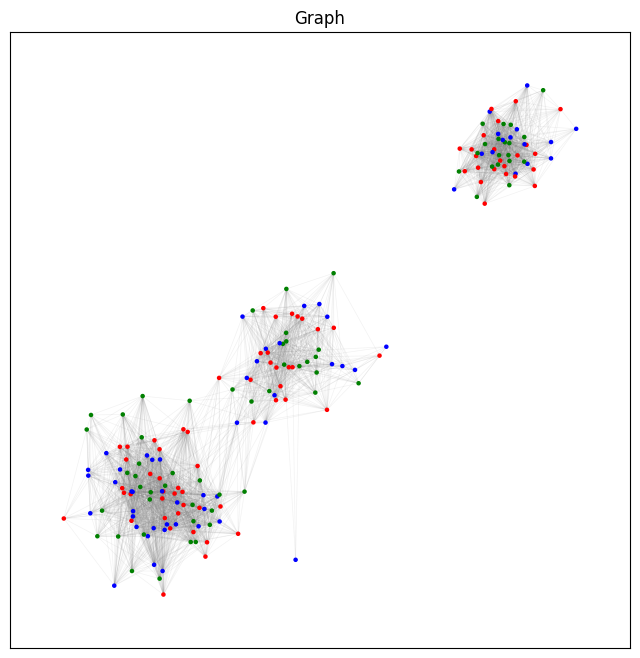

In [239]:
n_nodes = 200
features = gglm.num_features #np.random.rand(n_nodes, 2)
categories = np.random.randint(0, 3, size=(n_nodes, 1)) 

G = gglm.Nx
node_idx = list(range(n_nodes))

# Assign 2D position to each node based on features
for i in node_idx:
    G.nodes[i]['pos'] = features[i]
    G.nodes[i]['category'] = categories[i, 0]


# Extract positions
pos = {node: data['pos'] for node, data in G.nodes(data=True)}
color_map = {0: 'red', 1: 'green', 2: 'blue'}

node_colors = [color_map[G.nodes[i]['category']] for i in G.nodes()]


plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=.5, alpha=.1)

plt.title('Graph')
plt.axis('on')  
plt.show()


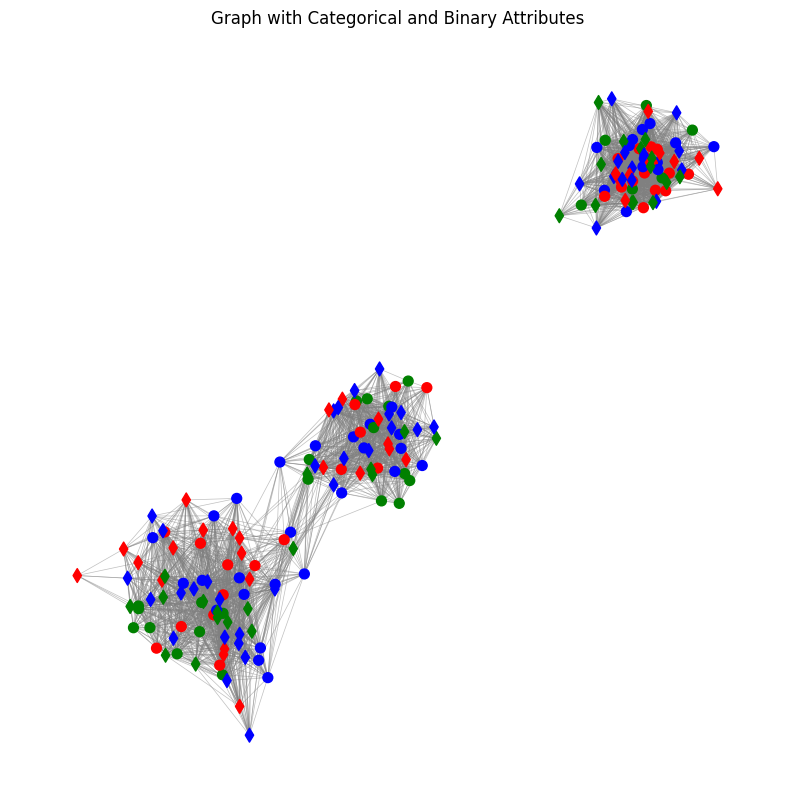

In [230]:
n_nodes = 200
features = gglm.num_features 
categories = np.random.randint(0, 3, size=(n_nodes, 1)) 
target = binary_labels = np.random.randint(0, 2, size=n_nodes)

G = gglm.Nx
node_idx = list(range(n_nodes))

# Assign 2D position to each node based on features
for i in node_idx:
    G.nodes[i]['pos'] = features[i]
    G.nodes[i]['category'] = categories[i, 0]
    G.nodes[i]['target'] = target[i]

pos = {node: data['pos'] for node, data in G.nodes(data=True)}
color_map = {0: 'red', 1: 'green', 2: 'blue'}
shape_map = {0: 'o', 1: 'd'} 

plt.figure(figsize=(10, 10))
for shape in shape_map:
    nodelist = [node for node in G.nodes() if G.nodes[node]['target'] == shape]
    node_colors = [color_map[G.nodes[node]['category']] for node in nodelist]
    nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_colors, node_size=50, node_shape=shape_map[shape])

nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5)

plt.title('Graph')
plt.axis('off')  
plt.show()

